In [531]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [532]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklego.preprocessing import InformationFilter
from sklego.metrics import p_percent_score, equal_opportunity_score

In [533]:
from sklearn.linear_model import LogisticRegression
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier

In [534]:
# NOTE: we are using demographic parity of our measure of fairness (equal probility of approval across sensitive attribute),
# sklego has a metric called p_percent_score that quantifies this measure of fairness
# However, the sensitive variable must be in the dataset that the model is trained on in order to calculate
# p_percent_score using sklego's p_percent_score
# Therefore, because we want to benchmark fairness with a model that uses an information filter on gender, as well as
# a model that drops gender prior to training (fairness through unawareness), I have created my own function that 
# calculates p % scores without requiring gender to be present in the dataset when training the model

def my_p_percent(model, xtrain, df, z):
    y_hat = model.predict(xtrain)
    y_hat_z0 = []
    y_hat_z1 = []
    
    for i in range(len(y_hat)):
    #check if xtrain index corresponds to z0 or z1:
        if df.iloc[xtrain.index[i]][z] == 0:
            y_hat_z0.append(y_hat[i])
        else:
            y_hat_z1.append(y_hat[i])
    y_hat_z0_pos_target = []
    y_hat_z1_pos_target = []
    
    for pred in y_hat_z0:
        if pred == 1:
            y_hat_z0_pos_target.append(pred)
    
    for pred in y_hat_z1:
        if pred == 1:
            y_hat_z1_pos_target.append(pred)
            
    p_y1_z0 = len(y_hat_z0_pos_target)/len(y_hat_z0)
    p_y1_z1 = len(y_hat_z1_pos_target)/len(y_hat_z1)
    
    return np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)

# German Credit Dataset

## data loading/manipulation

In [535]:
# column names
cols = ['existing_checking', 'duration(months)', 'credit_history', 'purpose', 'credit_amount',
         'savings_account', 'employment_since', 'installment_rate', 'status_and_sex', 'other_debtors',
         'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
         'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'classification']

In [536]:
# load data
df=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", names= cols, delimiter=' ')

In [537]:
df.head(10)

,existing_checking,duration(months),credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,status_and_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [538]:
# numerical features
num_features = ['credit_amount', 'duration(months)', 'installment_rate', 'residence_since', 'age',
           'existing_credits', 'people_liable']

In [539]:
# normalize data
df[num_features] = StandardScaler().fit_transform(df[num_features])

In [540]:
# categorical features
cat_features = ['existing_checking', 'credit_history', 'purpose', 'savings_account', 'employment_since',
            'other_debtors', 'property', 'other_installment_plans', 'housing', 'job',
           'telephone', 'foreign_worker']

## Feature Engineering: Attribute 9

### Reference for Attribute 9:
```
Attribute 9: (qualitative)
Personal status and sex
A91 : male : divorced/separated
A92 : female : divorced/separated/married
A93 : male : single
A94 : male : married/widowed
A95 : female : single 
```

In [542]:
# NOTE: given that we're treating gender as the sensitive varibale, we decided to separate 
# attribute 9 (sex_and_status) into two distinct variables: 1. gender 2. personal_status
# Isolating the gender variable allows us to build a model with a fairness constraint on gender

In [543]:
# create gender column and personal_status column
df['gender'] = np.nan
df['personal_status'] = np.nan

In [544]:
# separate attribute 9 (sex_and_status) into two columns: gender, personal_status
for index, row in df.iterrows():
    if row['status_and_sex'] == 'A91':
        # male
        df.loc[index, 'gender'] = 0

        # divorced/separated
        df.loc[index, 'personal_status'] = 1

        #print('mutated row = ', df.iloc[index])
    if row['status_and_sex'] == 'A92':
        # female
        df.loc[index, 'gender'] = 1
        # divorced/separated/married
        df.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A93':
        # male
        df.loc[index, 'gender'] = 0
        # single
        df.loc[index, 'personal_status'] = 0

    if row['status_and_sex'] == 'A94':
        # male
        df.loc[index, 'gender'] = 0
        # married/widowed
        df.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A95':
        # female
        df.loc[index, 'gender'] = 1
        # single
        df.loc[index, 'personal_status'] = 0

In [545]:
# gender, personal_status column after feature engineering transformation
df[['gender', 'personal_status']].head(6)

,gender,personal_status
0,0.0,0.0
1,1.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [547]:
# gain insight into the distribution of approvals for men and women
approved_men = 0
approved_women = 0
for index, row in df.iterrows():
    if row['gender'] == 0 and row['classification'] == 1:
        approved_men += 1
    if row['gender'] == 1 and row['classification'] == 1:
        approved_women += 1
print('# of approved men = ', approved_men)
print('# of approved women = ', approved_women)

# of approved men =  499
# of approved women =  201


In [548]:
# now that we've separated sex_status into two columns, we can now delete the sex_status column
df = df.drop('status_and_sex', axis=1)

In [550]:
# one-hot encoding each of every categorical features
df = pd.get_dummies(df, columns = cat_features)

In [552]:
# replace labels with 1=good, 0=bad
df.classification.replace([1,2], [1,0], inplace=True)

# Benchmarking: 
## There are three ways we would like to train our data in order to create benchmarks:
### 1. Dataset containing all original information (including gender)
### 2. Dataset not containing gender (fairness through unawareness) 
### 3. Dataset with information filter on gender column

In [553]:
# define x as all columns except for last column which contains labels
x = df.drop('classification', axis = 1)

# fairness through unaware benchmark comparison (dropping gender column prior to training)
x_unaware = df.drop(['classification', 'gender'], axis = 1)

# information filter on gender column
x_infoFilter = InformationFilter('gender').fit_transform(x)
x_infoFilter = pd.DataFrame(x_infoFilter, columns=[n for n in x.columns if n not in ['gender']])

In [554]:
y = df.classification

In [555]:
# 80/20 split for train/test
#xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

#xtrain_unaware, xtest_unware, ytrain_unaware, ytest_unware = train_test_split(x_unaware, y, test_size = 0.2, random_state = 0)

#xtrain_infoFilter, xtest_infoFilter, ytrain_infoFilter, ytest_infoFilter = train_test_split(x_infoFilter, y, test_size = 0.2, random_state = 0)

In [556]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [557]:
# model evaluation metrics 
f2 = make_scorer(fbeta_score, beta=2)
mean_accuracy=[]
mean_f2=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents=[]
equal_opp=[]

In [558]:
# baseline model evaluation metrics
f2_unaware = make_scorer(fbeta_score, beta=2)
mean_accuracy_unaware=[]
mean_f2_unaware=[]
mean_precision_unaware=[]
mean_recall_unaware=[]
accuracy_std_unaware=[]
p_percents_unaware=[]
equal_opp_unaware=[]

In [559]:
# information filter model evaluation metrics
f2_infoFilter = make_scorer(fbeta_score, beta=2)
mean_accuracy_infoFilter=[]
mean_f2_infoFilter=[]
mean_precision_infoFilter=[]
mean_recall_infoFilter=[]
accuracy_std_infoFilter=[]
p_percents_infoFilter=[]
equal_opp_infoFilter=[]

In [560]:
# classifiers
classifiers=['Logistic Regression', 'Demographic Parity Cov_Threshold=1', 'Demographic Parity Cov_Threshold=0', 'Equal Opportunity']
models=[LogisticRegression(max_iter=5000), DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=1), DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.0), EqualOpportunityClassifier(sensitive_cols="gender", covariance_threshold=0.0000069, positive_target=True,)]

In [561]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2 = cross_val_score(model, x, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    equal_opp_score = equal_opportunity_score(sensitive_column="gender")(model, x, y)


    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    mean_f2.append(mean(cv_f2))
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents.append(p_percent)
    equal_opp.append(equal_opp_score)

In [562]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean f2beta': mean_f2, 'Mean precision':mean_precision, 'Mean recall':mean_recall, 'P%':p_percents, 'Equal Opp Score':equal_opp},index=classifiers)

In [563]:
# classifiers for information filter and fairness through unawareness evaluation 
classifiers_=['Logistic Regression']
models_ = models=[LogisticRegression(max_iter=5000)]

In [564]:
for model in models_:
    # accuracy
    cv_accuracy = cross_val_score(model,x_infoFilter,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2 = cross_val_score(model, x_infoFilter, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x_infoFilter, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x_infoFilter, y, scoring='recall', cv=cv, n_jobs=-1)
    
    model.fit(x_infoFilter, y)
    p_percent_infoFilter = my_p_percent(model, x_infoFilter, df, z="gender" )

    mean_accuracy_infoFilter.append(mean(cv_accuracy))
    accuracy_std_infoFilter.append(cv_accuracy.std())
    mean_f2_infoFilter.append(mean(cv_f2))
    mean_precision_infoFilter.append(mean(cv_precision))
    mean_recall_infoFilter.append(mean(cv_recall))
    p_percents_infoFilter.append(p_percent_infoFilter)

In [565]:
models_dataframe_infoFilter=pd.DataFrame({'Information filter Mean Accuracy':mean_accuracy_infoFilter, 'Information filter Accuracy Std':accuracy_std_infoFilter, 'Information filter Mean f2beta': mean_f2_infoFilter, 'Information filter Mean precision':mean_precision_infoFilter, 'Information filter Mean recall':mean_recall_infoFilter, 'P %': p_percents_infoFilter},index=classifiers_)

In [566]:
# baseline comparision (fairness through unawareness)

for model in models_:
    # accuracy
    cv_accuracy_unaware = cross_val_score(model,x_unaware,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2_unaware = cross_val_score(model, x_unaware, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision_unaware = cross_val_score(model, x_unaware, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall_unaware = cross_val_score(model, x_unaware, y, scoring='recall', cv=cv, n_jobs=-1)
    
    model.fit(x_unaware, y)
    p_percent_unaware = my_p_percent(model, x_unaware, df, z="gender" )
    
    
    mean_accuracy_unaware.append(mean(cv_accuracy_unaware))
    accuracy_std_unaware.append(cv_accuracy_unaware.std())
    mean_f2_unaware.append(mean(cv_f2_unaware))
    mean_precision_unaware.append(mean(cv_precision_unaware))
    mean_recall_unaware.append(mean(cv_recall_unaware))
    p_percents_unaware.append(p_percent_unaware)

In [567]:
models_dataframe_unaware=pd.DataFrame({'Gender-removed Mean Accuracy':mean_accuracy_unaware, 'Gender-removed Accuracy Std':accuracy_std_unaware, 'Gender-removed Mean f2beta': mean_f2_unaware, 'Gender-removed Mean Precision':mean_precision_unaware, 'Gender-removed Mean recall':mean_recall_unaware, 'Gender-removed P %': p_percents_unaware},index=classifiers_)

## Benchmark Results

In [568]:
# NOTE: Baseline comparison: if we predicted loan approval for every single applicant
# this approach would yeild an accuracy score of 70% because 700 of the 1000 applicants 
# received a loan in the dataset.
# Dataset p_percent_score: If we correctly predicted every individual, the following would be the p percent score.
# In other words, the p_percent_score of the dataset labels 
p_y1_z0 = 499/690
p_y1_z1 = 201/310
dataset_p_percent = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
dataset_p_percent

0.8965673282047968

In [569]:
baseline_dataframe = pd.DataFrame({'Baseline accuracy': [0.70]}, index=['Baseline'])
baseline_dataframe

,Baseline accuracy
Baseline,0.7


In [570]:
# results for models training using original dataset (gender column included)
models_dataframe

,Mean Accuracy,Accuracy Std,Mean f2beta,Mean precision,Mean recall,P%,Equal Opp Score
Logistic Regression,0.761000,0.031660,0.861042,0.800754,0.878095,0.855157,0.943929
Demographic Parity Cov_Threshold=1,0.760667,0.033460,0.860040,0.801215,0.876667,0.842197,0.929603
Demographic Parity Cov_Threshold=0,0.756000,0.031581,0.856983,0.797557,0.873810,0.989247,0.958852
Equal Opportunity,0.752667,0.033559,0.852824,0.796853,0.868571,0.998215,0.955288


In [571]:
# results for model trained using information filter on gender
models_dataframe_infoFilter

,Information filter Mean Accuracy,Information filter Accuracy Std,Information filter Mean f2beta,Information filter Mean precision,Information filter Mean recall,P %
Logistic Regression,0.760667,0.030977,0.860956,0.80043,0.878095,0.856695


In [572]:
# results for model trained without gender column (fairness through unawareness), intended as a baseline comparison
models_dataframe_unaware

,Gender-removed Mean Accuracy,Gender-removed Accuracy Std,Gender-removed Mean f2beta,Gender-removed Mean Precision,Gender-removed Mean recall,Gender-removed P %
Logistic Regression,0.76,0.032558,0.860187,0.800209,0.877143,0.855157


In [392]:
# NOTE: given the accuracy of predicting that every applicant received a loan is 70% (baseline), this shows that 
# the strongly fair models (e.g. demographic parity classifier with cov_threshold of 0) is still learning something
# useful from the data given that 0.756 is measurably higher than 0.7

# Exploration of covariance threshold: Demographic Parity Classifier 

In [393]:
dpc_clf = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.5)

In [394]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [395]:
grid_dpc = GridSearchCV(estimator=dpc_clf, param_grid={"estimator__covariance_threshold":np.linspace(0, 1.00, 50)}, cv=6, return_train_score=True, refit="p_percent_score", scoring={"p_percent_score":p_percent_score('gender'), "accuracy_score":make_scorer(accuracy_score)})

In [396]:
grid_dpc.fit(x,y)

GridSearchCV(cv=6,
             estimator=OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0.5,
                                                                                  sensitive_cols='gender'),
                                           n_jobs=1),
             param_grid={'estimator__covariance_threshold': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.285...
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             refit='p_percent_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'p_percent_score': <function

In [397]:
results_dpc = (pd.DataFrame(grid_dpc.cv_results_).set_index("param_estimator__covariance_threshold"))

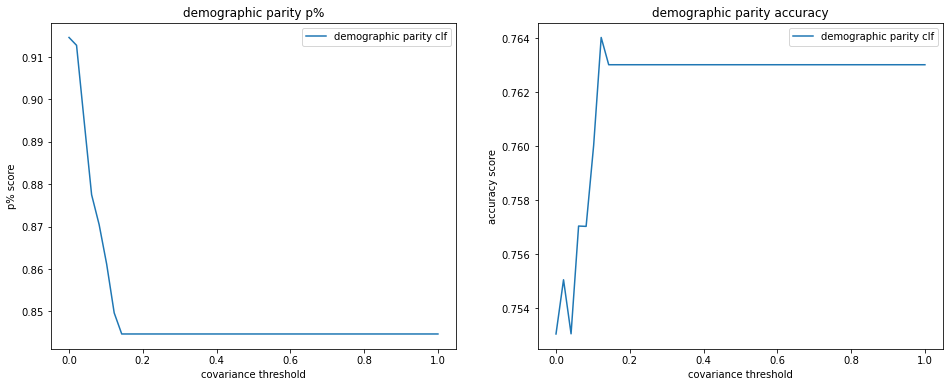

In [398]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_p_percent_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('p% score')
plt.legend()
plt.title("demographic parity p%")
plt.subplot(122)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_accuracy_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('accuracy score')
plt.legend()
plt.title("demographic parity accuracy");

In [399]:
# NOTE: it's clear that p% is influenced by covariance threshold for dpc model, which makes sense given 
# that cov_threshold represents the maximum allowed covariance between the sensitive attributes and the 
# distance to the decision boundary. 
# Thus, it would be interesting to explore how feature coefficients change as covariance threshold changes

## Exploration of how feature importance changes as a function of covariance threshold 

In [400]:
# NOTE: Features that are binary variables (e.g. personal_status) will need larger coefficients to affect 
# the final outcome, while features that contain a wide range of values (e.g. credit_amount) will have significant
# impact on the final prediction even when coefficient is small.
# Therefore, we are measuring the overall importance of a feature by multiplying 
# feature weight * absolute value of that feature's column

In [401]:
dpc = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=1)

In [402]:
dpc.fit(x, y)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=1,
                                                           sensitive_cols='gender'),
                    n_jobs=1)

In [403]:
dpc_features = x.columns.drop('gender')

In [589]:
# confirming that I can assign all features to their corresponding coefficients 
coef_dict = {}
for coef, feat in zip(dpc.coef_[0,:],dpc_features):
    coef_dict[feat] = coef
coef_dict

{'duration(months)': -0.33786868476164805,
 'credit_amount': -0.35726536837699185,
 'installment_rate': -0.3594758173177607,
 'residence_since': -0.004201731525635283,
 'age': 0.15272118691874087,
 'existing_credits': -0.15157222527834363,
 'people_liable': -0.09454276763553268,
 'personal_status': -0.5476509857620888,
 'existing_checking_A11': -0.756681493116547,
 'existing_checking_A12': -0.37474523500290646,
 'existing_checking_A13': 0.18491105426499244,
 'existing_checking_A14': 0.9465156738609733,
 'credit_history_A30': -0.5232760847615877,
 'credit_history_A31': -0.658313326678301,
 'credit_history_A32': 0.035092368784475296,
 'credit_history_A33': 0.2809559327834713,
 'credit_history_A34': 0.8655411098780548,
 'purpose_A40': -0.7877501107092298,
 'purpose_A41': 0.8454347663985474,
 'purpose_A410': 0.5727038514160212,
 'purpose_A42': -0.0320332100486613,
 'purpose_A43': 0.10620030308078639,
 'purpose_A44': -0.2281138244021877,
 'purpose_A45': -0.5405683820858171,
 'purpose_A46': 

In [581]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []
feature_dict

{'duration(months)': [],
 'credit_amount': [],
 'installment_rate': [],
 'residence_since': [],
 'age': [],
 'existing_credits': [],
 'people_liable': [],
 'personal_status': [],
 'existing_checking_A11': [],
 'existing_checking_A12': [],
 'existing_checking_A13': [],
 'existing_checking_A14': [],
 'credit_history_A30': [],
 'credit_history_A31': [],
 'credit_history_A32': [],
 'credit_history_A33': [],
 'credit_history_A34': [],
 'purpose_A40': [],
 'purpose_A41': [],
 'purpose_A410': [],
 'purpose_A42': [],
 'purpose_A43': [],
 'purpose_A44': [],
 'purpose_A45': [],
 'purpose_A46': [],
 'purpose_A48': [],
 'purpose_A49': [],
 'savings_account_A61': [],
 'savings_account_A62': [],
 'savings_account_A63': [],
 'savings_account_A64': [],
 'savings_account_A65': [],
 'employment_since_A71': [],
 'employment_since_A72': [],
 'employment_since_A73': [],
 'employment_since_A74': [],
 'employment_since_A75': [],
 'other_debtors_A101': [],
 'other_debtors_A102': [],
 'other_debtors_A103': [],

In [68]:
cov_threshold = np.linspace(0,1,60)

In [69]:
# build demographic parity models with 60 different covariance thresholds, storing each corresponding
# feature coefficient in the above dictionary, allowing us to see how each feature's coefficients change as a function
# of covariance threshold 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        #print(feat, 'coef =', coef)
        #print(feat,'column mean = ', abs(df[feat].mean()) )
        #print(feat, 'coef*mean = ', coef*abs(df[feat].mean()))
        feature_dict[feat].append([cov,coef*abs(df[feat].mean()),p_percent])


In [329]:
# format = {'feature': [covariance threshold, feature coef * average abs of feature column, p_percent]}
feature_dict['residence_since']

[[0.0, 6.9000057198361416e-18, 0.9892473118279569],
 [0.006896551724137932, 6.375715820252398e-18, 0.9664685908319184],
 [0.013793103448275864, 5.853932004015867e-18, 0.9586806814063067],
 [0.020689655172413796, 5.334567914333501e-18, 0.9509508907077516],
 [0.027586206896551727, 4.8175379009624984e-18, 0.9326004685528925],
 [0.03448275862068966, 4.3027527411443895e-18, 0.9267298237198704],
 [0.04137931034482759, 3.7901290528732304e-18, 0.9174765965058733],
 [0.048275862068965524, 3.2795753734787227e-18, 0.911677181287942],
 [0.055172413793103454, 2.7710056752643594e-18, 0.9075705273181764],
 [0.062068965517241385, 2.264331281639232e-18, 0.9042338709677419],
 [0.06896551724137932, 1.7594627381950785e-18, 0.9058991267153805],
 [0.07586206896551725, 1.2563132841346613e-18, 0.8952055198443121],
 [0.08275862068965519, 7.547949816854159e-19, 0.8895102425241346],
 [0.08965517241379312, 2.5482027246763557e-19, 0.8797814207650273],
 [0.09655172413793105, -2.43699974358682e-19, 0.868508869504127

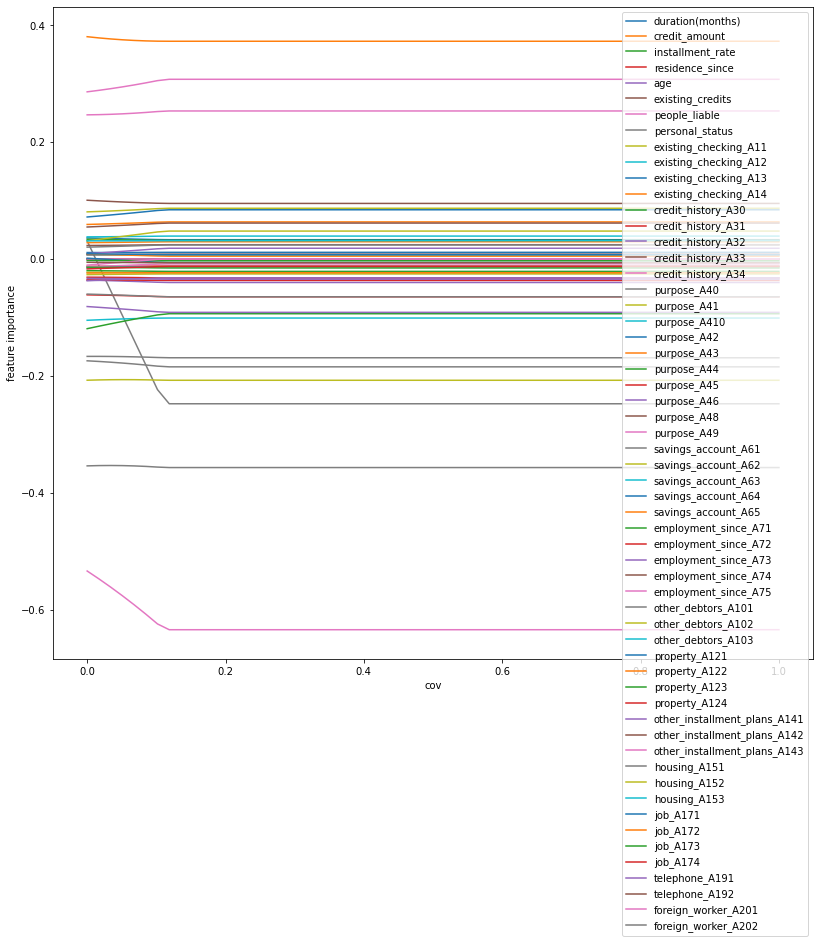

In [71]:
plt.figure(figsize=(30,12))
plt.subplot(121)

for feature in feature_dict:
    xs = [x[0] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
plt.xlabel("cov")
plt.ylabel('feature importance')
plt.legend()

In [72]:
# NOTE: all feature coefficients flatline slightly before a covariance threshold of 0.2

In [582]:
cov_threshold = np.linspace(0.0,0.2, 30)

In [583]:
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    df_a = df.copy()
    for feature in df_a.columns.tolist():
        df_a[feature] = abs(df_a[feature])
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,coef*df_a[feat].mean(),p_percent])

In [584]:
# format = {'feature': [covariance threshold, feature importance, p_percent]}
feature_dict['duration(months)']

[[0.0, -0.26209790409176287, 0.9892473118279569],
 [0.006896551724137932, -0.26209883902827574, 0.9664685908319184],
 [0.013793103448275864, -0.26213322910207476, 0.9586806814063067],
 [0.020689655172413796, -0.26220112782580374, 0.9509508907077516],
 [0.027586206896551727, -0.2623025647625682, 0.9326004685528925],
 [0.03448275862068966, -0.2624375701164348, 0.9267298237198704],
 [0.04137931034482759, -0.26260614835404084, 0.9174765965058733],
 [0.048275862068965524, -0.2628083059843756, 0.911677181287942],
 [0.055172413793103454, -0.2630440317450253, 0.9075705273181764],
 [0.062068965517241385, -0.2633133037359595, 0.9042338709677419],
 [0.06896551724137932, -0.2636160886564511, 0.9058991267153805],
 [0.07586206896551725, -0.263952348121778, 0.8952055198443121],
 [0.08275862068965519, -0.2643220251765773, 0.8895102425241346],
 [0.08965517241379312, -0.26472505617773906, 0.8797814207650273],
 [0.09655172413793105, -0.26516136797881523, 0.8685088695041274],
 [0.10344827586206898, -0.265

In [585]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in feature_dict:
    df = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df.sort_values('p percent')
    df = df.reset_index(drop=True)
    most_fair = df.at[0,f"{feature}_importance"]
    least_fair = df.at[29, f"{feature}_importance"]
    fairness_delta = most_fair - least_fair
    delta_list.append(fairness_delta)
print('df foreign worker_A202 = \n', df.head(30))    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])
#feature_fairness_delta_sort
features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])


df foreign worker_A202 = 
          cov  foreign_worker_A202_importance  p percent
0   0.000000                        0.020509   0.989247
1   0.006897                        0.020716   0.966469
2   0.013793                        0.020927   0.958681
3   0.020690                        0.021142   0.950951
4   0.027586                        0.021362   0.932600
5   0.034483                        0.021585   0.926730
6   0.041379                        0.021813   0.917477
7   0.048276                        0.022045   0.911677
8   0.055172                        0.022281   0.907571
9   0.062069                        0.022522   0.904234
10  0.068966                        0.022767   0.905899
11  0.075862                        0.023016   0.895206
12  0.082759                        0.023270   0.889510
13  0.089655                        0.023528   0.879781
14  0.096552                        0.023791   0.868509
15  0.103448                        0.024058   0.854839
16  0.110345         

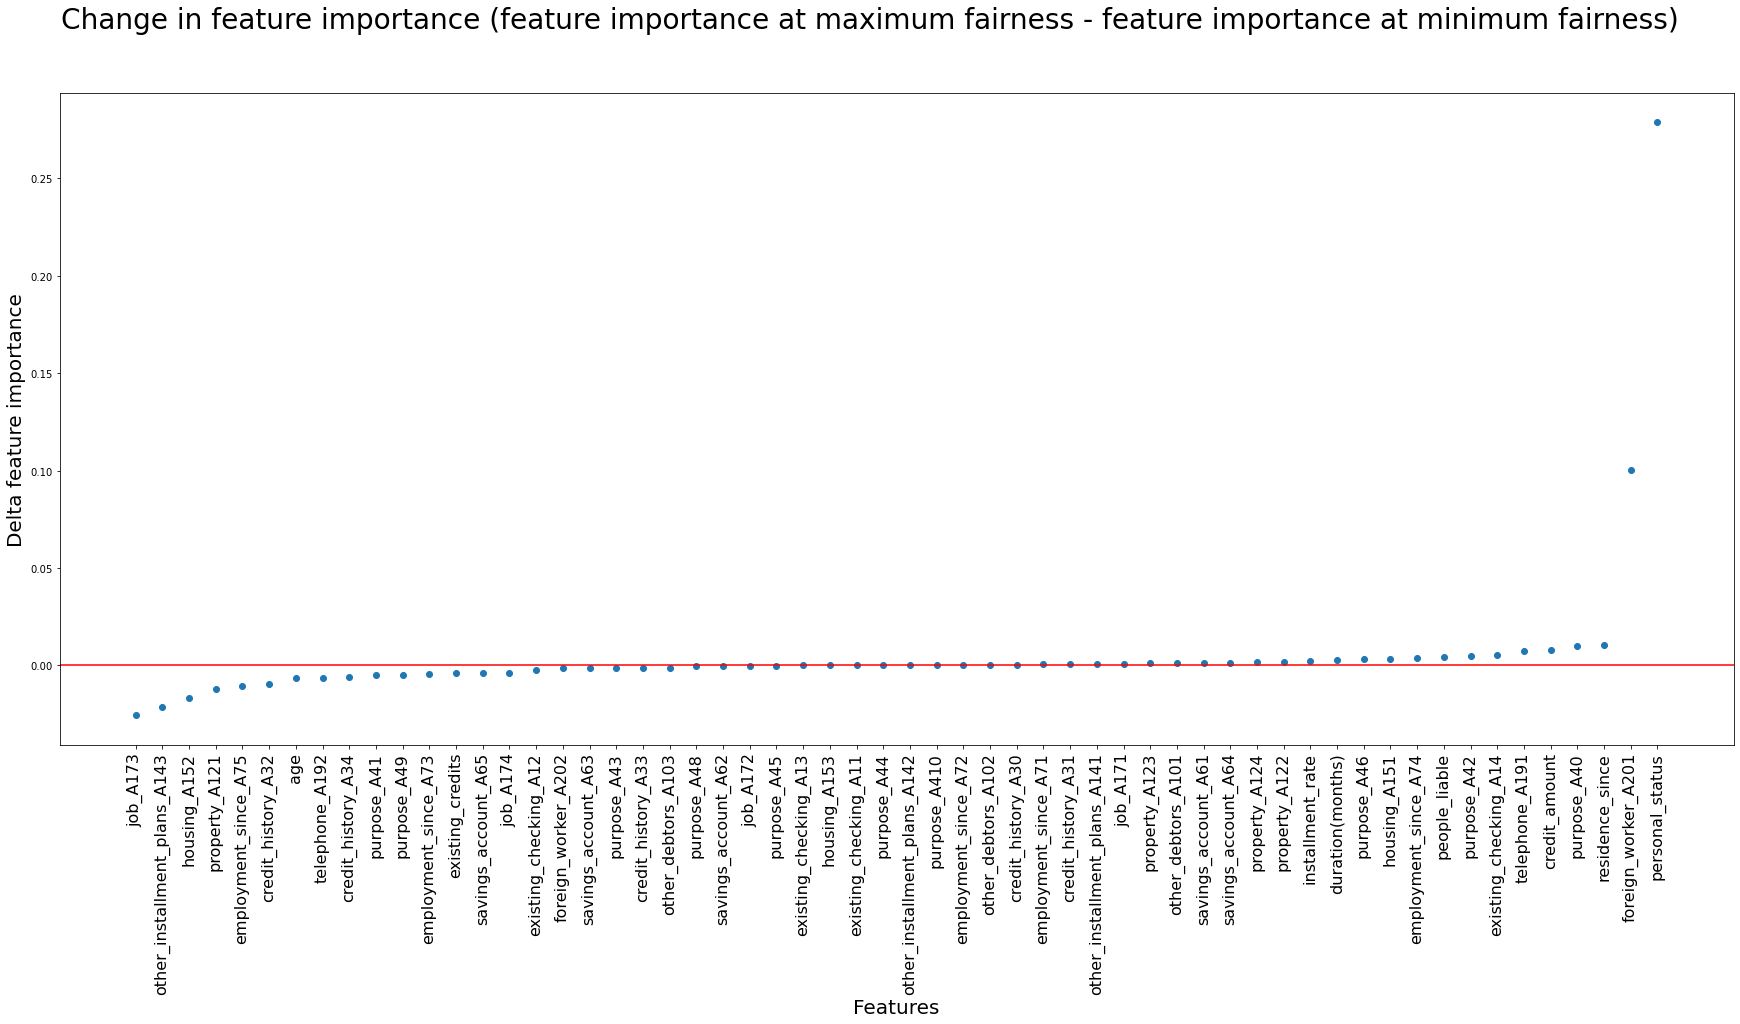

In [586]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_coef)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=16)
figure.suptitle('Change in feature importance (feature importance at maximum fairness - feature importance at minimum fairness)', fontsize=28)
plt.xlabel("Features", fontsize=20)
plt.ylabel('Delta feature importance', fontsize=20)
ax.axhline(y=0, color="red")
plt.show()


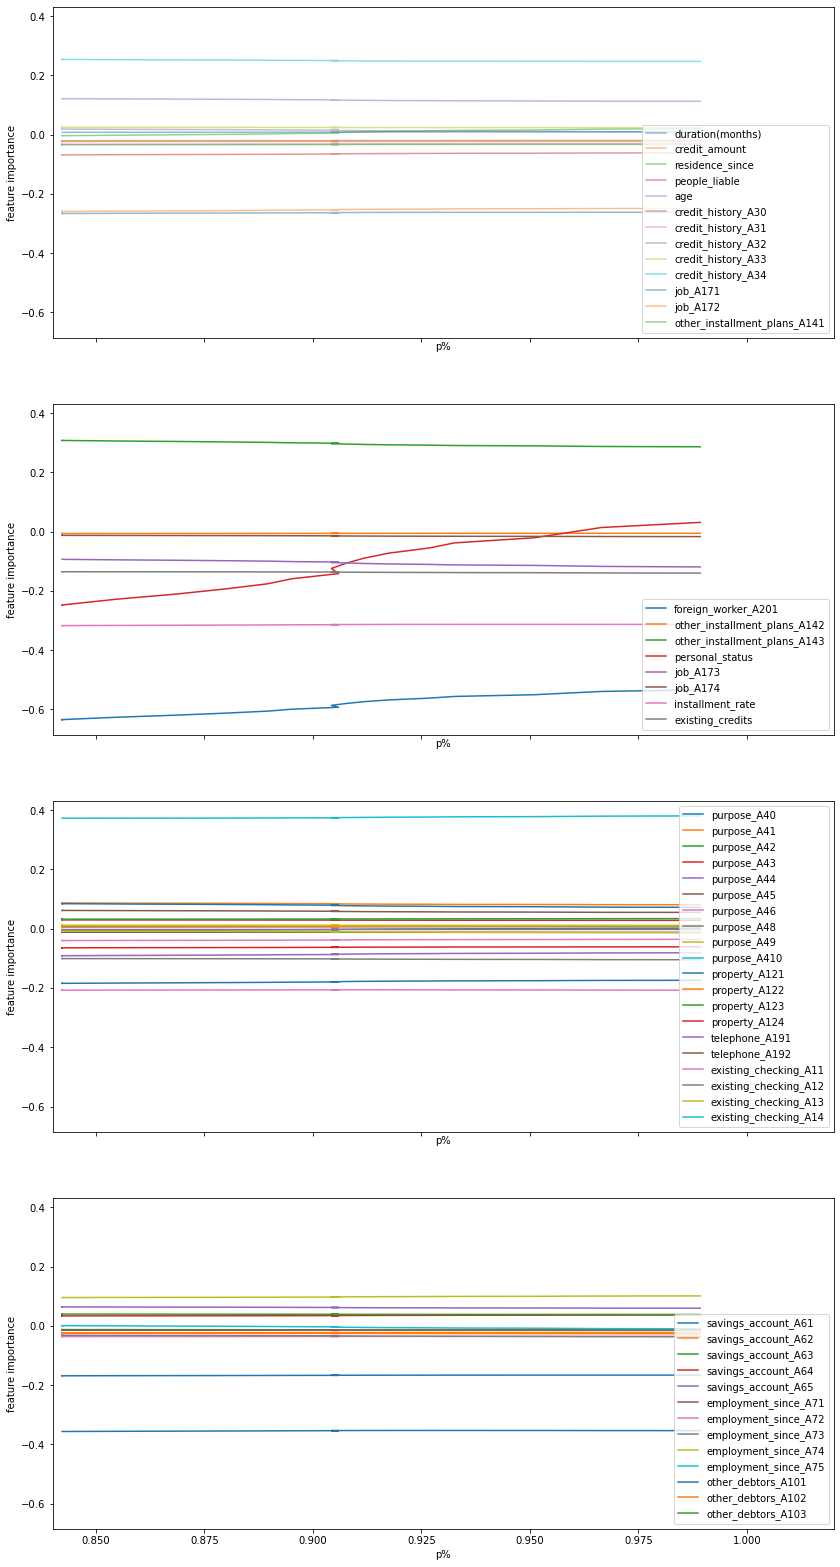

In [587]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(14,28))



#plt.figure(figsize=(18,7))
#plt.subplot(121, sharex=True, sharey=True)

for feature in ['duration(months)', 'credit_amount', 'residence_since', 'people_liable', 'age', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'job_A171', 'job_A172', 'other_installment_plans_A141']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[0].plot(xs,ys,alpha=0.5, label=feature)

plt.xlabel("p%")
plt.ylabel('feature importance')
plt.xlim((0.84, 1.02))
ax[0].legend()
ax[0].set_xlabel("p%")
ax[0].set_ylabel("feature importance")
# plt.subplot(122)
for feature in ['foreign_worker_A201', 'other_installment_plans_A142', 'other_installment_plans_A143','personal_status', 'job_A173', 'job_A174', 'installment_rate', 'existing_credits']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[1].plot(xs,ys,label=feature)
ax[1].legend()
ax[1].set_xlabel("p%")
ax[1].set_ylabel("feature importance")
for feature in ['purpose_A40', 'purpose_A41', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'purpose_A410', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'telephone_A191', 'telephone_A192', 'existing_checking_A11', 'existing_checking_A12', 'existing_checking_A13', 'existing_checking_A14',]:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[2].plot(xs,ys,label=feature)
ax[2].legend()
ax[2].set_xlabel("p%")
ax[2].set_ylabel("feature importance")
for feature in ['savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'other_debtors_A101', 'other_debtors_A102', 'other_debtors_A103']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax[3].plot(xs,ys,label=feature)
ax[3].legend()
# plt.xlabel("p%")
# plt.ylabel('feature importance')
# plt.ylim((-0.6,0.6))
#ax[2].yaxis.set_ticks(np.linspace(-0.2,0.1,7))
plt.legend()